**Implementing Label Spreading for Data classification**




In [23]:
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [24]:
# Data exploration.

n_samples = 200
X, y = make_circles(n_samples = n_samples, shuffle=False)
outer, inner = 0, 1
labels = -np.ones(n_samples)
labels[0] = outer
labels[-1] = inner

y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [25]:
labels.astype(int)

array([ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1])

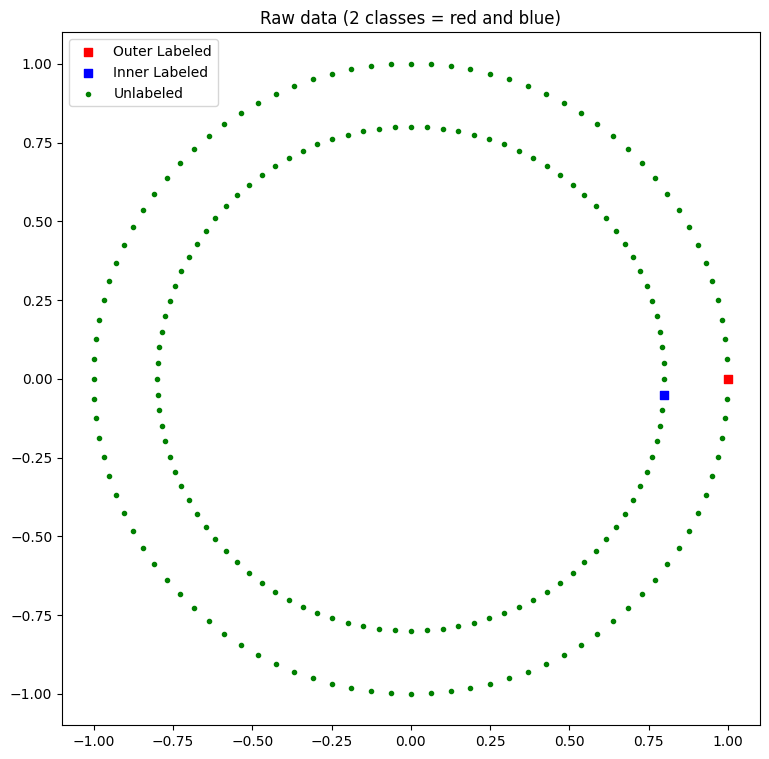

In [26]:
plt.figure(figsize=(9, 9))

# Plot labeled points
plt.scatter(X[labels == outer, 0], X[labels == outer, 1], color='red', marker='s', label='Outer Labeled')
plt.scatter(X[labels == inner, 0], X[labels == inner, 1], color='blue', marker='s', label='Inner Labeled')

# Plot unlabeled points
plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='green', marker='.', label='Unlabeled')

# Set legend and title
plt.legend(loc='upper left', numpoints=1)
plt.title("Raw data (2 classes = red and blue)")

# Show the plot
plt.show()

In [27]:
from abc import ABCMeta, abstractmethod
from scipy import sparse
from scipy.sparse import csgraph
import warnings
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import ConvergenceWarning
from sklearn.semi_supervised._label_propagation import BaseLabelPropagation

## LabelSpreading class
  Defines the LabelSpreading class and provide the necessary methods to build the graph and compute the graph Laplacian for label spreading.<br>


  The _build_graph method is responsible for constructing the graph Laplacian. <br>
  It first computes the affinity matrix using the specified kernel. <br>
  Then, it computes the normalized Laplacian matrix by subtracting the laplacian matrix from the affinity matrix. <br>
  Finally, it sets the diagonal elements of the Laplacian matrix to zero.<br>

In [28]:
class LabelSpreading(BaseLabelPropagation):
    _variant = "spreading"

    def __init__(
        self,
        kernel="rbf",
        *,
        gamma=20,
        n_neighbors=7,
        alpha=0.2,
        max_iter=30,
        tol=1e-3,
        n_jobs=None,
    ):

        # substituting the base parameters
        super().__init__(
            kernel=kernel,
            gamma=gamma,
            n_neighbors=n_neighbors,
            alpha=alpha,
            max_iter=max_iter,
            tol=tol,
            n_jobs=n_jobs,
        )

    def _build_graph(self):
        #Graph matrix for Label Spreading computes the graph laplacian
        if self.kernel == "knn":
            self.nn_fit = None
        n_samples = self.X_.shape[0]
        affinity_matrix = self._get_kernel(self.X_)

        #compute affinity matrix (or gram matrix)
        laplacian = csgraph.laplacian(affinity_matrix, normed=True)
        laplacian = -laplacian
        if sparse.isspmatrix(laplacian):
            diag_mask = laplacian.row == laplacian.col
            laplacian.data[diag_mask] = 0.0
        else:
            laplacian.flat[:: n_samples + 1] = 0.0
        return laplacian

In [29]:
label_spread = LabelSpreading(kernel='knn', alpha=0.9)
label_spread.fit(X, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


LabelSpreading(alpha=0.9, kernel='knn')

## Plot and sub plot

  The scatter function from matplotlib to plot the labeled and unlabeled points. The subplot creation and arrangement are simplified using the subplots function.<br>
  The c parameter is used to set the color for each point group. The legend is generated for each subplot individually. Overall, the code is condensed and more efficient for visualizing the labels.<br>

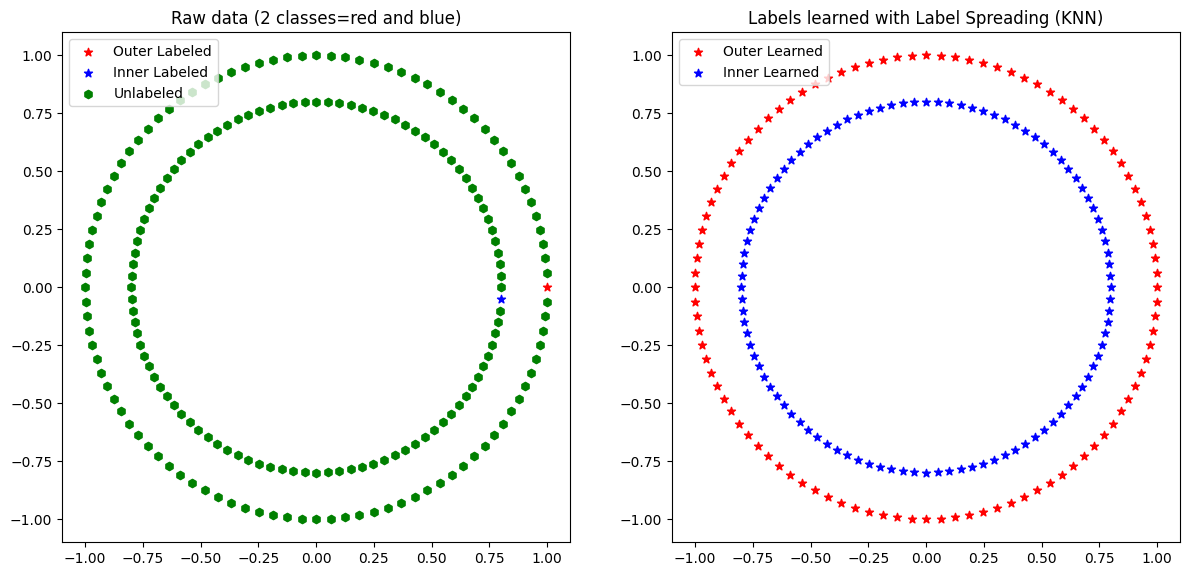

In [30]:
output_labels = label_spread.transduction_
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(13, 6))

ax1.scatter(X[labels == outer, 0], X[labels == outer, 1], c='red', marker='*', label='Outer Labeled')
ax1.scatter(X[labels == inner, 0], X[labels == inner, 1], c='blue', marker='*', label='Inner Labeled')
ax1.scatter(X[labels == -1, 0], X[labels == -1, 1], c='green', marker='h', label='Unlabeled')
ax1.legend(loc='upper left', numpoints=1)
ax1.set_title("Raw data (2 classes=red and blue)")

output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]

ax2.scatter(X[outer_numbers, 0], X[outer_numbers, 1], c='red', marker='*', label='Outer Learned')
ax2.scatter(X[inner_numbers, 0], X[inner_numbers, 1], c='blue', marker='*', label='Inner Learned')
ax2.legend(loc='upper left', numpoints=1)
ax2.set_title("Labels learned with Label Spreading (KNN)")

fig.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
pl.show()
